# Data Science Challenge
-----------------------

## [ Part. 1 ] Data preperation

## 1. Data pre-Processing

## 2. Feature engineering 

In [1]:
%load_ext autoreload
%autoreload 2

In [125]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

pd.options.display.max_columns = 50

from source.utils import haversine_distance 
from source.utils import get_trip_distance

%matplotlib inline

In [55]:
df_event = pd.read_csv('./data/events.csv')
df_iata = pd.read_csv('./data/iata.csv')

In [56]:
df_event.shape, df_iata.shape

((47007, 9), (500, 3))

## 1. Data pre-Processing

#### A. Check the NaN in the events data

In [57]:
df_event.isna().sum()

ts               0
event_type       0
user_id          0
date_from       22
date_to          3
origin           0
destination      0
num_adults       0
num_children     0
dtype: int64

##### [ Comments ] 
There is 2 columns with NaN. <br>
It seems like NaN data is relatively small compared to the size of the entire data. <br>
22 / 47007 , 3 / 47007 

#### B. Check the effectivness of this NaN data for task


In [58]:
df_event[df_event['date_to'].isna()]['event_type'].value_counts()

search    3
Name: event_type, dtype: int64

In [59]:
df_event[df_event['date_from'].isna()]['event_type'].value_counts()/len(df_event[df_event['date_from'].isna()]['event_type'])

search    0.954545
book      0.045455
Name: event_type, dtype: float64

##### [ Comments ]
NaN data contains Only 1 'book' event_type. <br>
From my understanding, 'book' event won't work without a 'date_from' and 'date_to'.<br>
So, this data is wrong some way.

#### When I drop NaN data, I want to make sure the same user is in the remaining data.

In [60]:
user_id_toNaN = df_event[df_event['date_to'].isna()]['user_id'].unique().tolist()

In [61]:
user_id_fromNaN = df_event[df_event['date_from'].isna()]['user_id'].unique().tolist()

In [62]:
drop_index = df_event[(df_event['date_to'].isna())|(df_event['date_from'].isna())].index

In [63]:
set(df_event.drop(drop_index, axis=0)['user_id'].unique()).intersection(user_id_toNaN)

set()

In [64]:
set(df_event.drop(drop_index, axis=0)['user_id'].unique()).intersection(user_id_fromNaN)

{'786588'}

In [65]:
df_event[df_event['user_id'] == '786588']

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children
41754,2017-04-27 13:20:22,search,786588,NaN,2017-06-28,AMS,MSP,0,0
45467,2017-04-27 13:07:25,search,786588,2017-06-14,2017-06-29,AMS,DTT,2,2


##### [ Comments ]
Only one user_id coexists with NaN data and dropped NaN data.<br>
Drop all NaN data <br>


In [66]:
df_event = df_event.drop(drop_index, axis=0)
df_event.shape

(46985, 9)

#### C. Check the uniquness of iata_code

In [67]:
df_iata.head(2)

,iata_code,lat,lon
0,LON,51.50,-0.17
1,MOW,55.75,37.70


In [68]:
len(set(df_event['origin'].unique())-set(df_iata['iata_code'].unique()))

0

In [69]:
len(set(df_event['destination'].unique())-set(df_iata['iata_code'].unique()))

0

In [70]:
df_iata['iata_code'].value_counts()[:5]

CKG    3
URC    3
RDU    3
LAS    2
BCN    2
Name: iata_code, dtype: int64

In [71]:
len(df_iata['iata_code'].unique())

298

##### [ Comments ]
There are some non-unique codes in iata data. So take only the first value.

In [72]:
df_iata = df_iata.drop_duplicates(['iata_code'])
df_iata.shape

(298, 3)

#### D. Change the datetime data type

In [73]:
datetime_columns = ['ts', 'date_from', 'date_to']

In [74]:
for col in datetime_columns:
    df_event[col] = df_event[col].astype('datetime64')


## 2. Feature Engineering

#### A. Add number of activities of uninque user

In [75]:
df_event = df_event.sort_values(by = ['user_id', 'ts'], ascending=True)

In [76]:
df_event['act_count'] = df_event.groupby('user_id').cumcount()+1

In [77]:
df_event[df_event['event_type']=='book']['user_id'].value_counts()[:5]

690a8c    3
08e914    2
57da52    2
d5eff6    1
87da05    1
Name: user_id, dtype: int64

##### [ Comments ]
Some users booked mutiple times


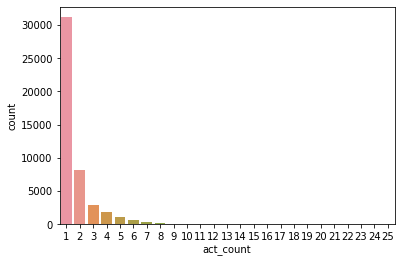

In [78]:
sns.countplot(df_event['act_count'])

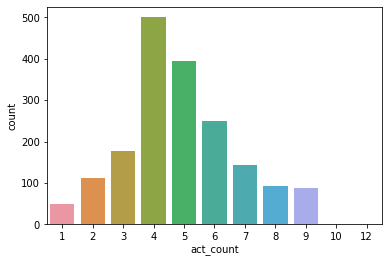

In [79]:
sns.countplot(df_event[df_event['event_type'] == 'book']['act_count'])

In [80]:
df_event[df_event['event_type'] == 'book'].shape

(1808, 10)

##### [ Comments ]
Featrue : 'act_count' is important for classifying 'book'.


#### B. Add time difference between actions for unique user
The first action for this number is 0 

In [81]:
# Change in sencods
df_event['diff_ts'] = df_event['ts'].diff()/np.timedelta64(1,'s') 
df_event['diff_ts'] = df_event['diff_ts'].fillna(0)
df_event['diff_ts'] = np.abs(df_event['diff_ts'] * (df_event['act_count']>1))
df_event['diff_ts'] = df_event['diff_ts'].astype('int')

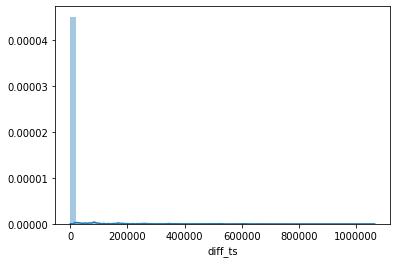

In [82]:
sns.distplot(df_event['diff_ts'])

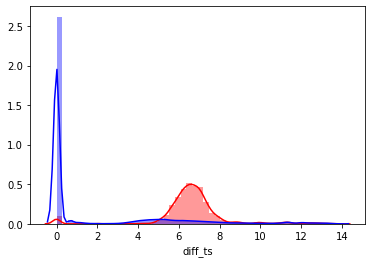

In [83]:
sns.distplot(np.log1p(df_event[df_event['event_type'] == 'book']['diff_ts']),
             color="red", label="book")
sns.distplot(np.log1p(df_event[df_event['event_type'] == 'search']['diff_ts']),
             color="blue", label="search")

##### [ Comments ]
Featrue : 'diff_ts' is important for classifying 'book'.


In [84]:
df_event['diff_ts'] = np.log1p(df_event['diff_ts'])

In [85]:
df_event[['diff_ts', 'act_count']].corr(method ='pearson')

,diff_ts,act_count
diff_ts,1.000000,0.593643
act_count,0.593643,1.000000


#### C. Add time feature of datetime columns
Usually user activities and trip plans shows seasonality <br>
This dataset has short period of time, so I added the<br>
- (1) Day of week for each datetime columns
- (2) 'Hours' of 'ts'
- (3) 'Days' for each datetime columns
- (4) 'trip_duration' in days




In [86]:
for col in datetime_columns:
    df_event[col+'_dow'] = df_event[col].dt.dayofweek

In [87]:
df_event['hours_ts'] = df_event['ts'].dt.hour

In [88]:
for col in datetime_columns:
    df_event[col+'_day'] = df_event[col].dt.day

In [89]:
df_event['trip_duration'] = (df_event['date_to'] - df_event['date_from'] )/np.timedelta64(1,'D')
df_event['trip_duration'] = df_event['trip_duration'].astype(int)

In [90]:
df_event.head(2)

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,act_count,diff_ts,ts_dow,date_from_dow,date_to_dow,hours_ts,ts_day,date_from_day,date_to_day,trip_duration
10873,2017-04-29 17:59:51,search,000069,2017-05-10,2017-05-26,FRA,ALG,2,3,1,0.0,5,2,4,17,29,10,26,16
12331,2017-04-28 19:14:23,search,00019d,2017-09-15,2017-10-13,PAR,SSA,4,0,1,0.0,4,4,4,19,28,15,13,28


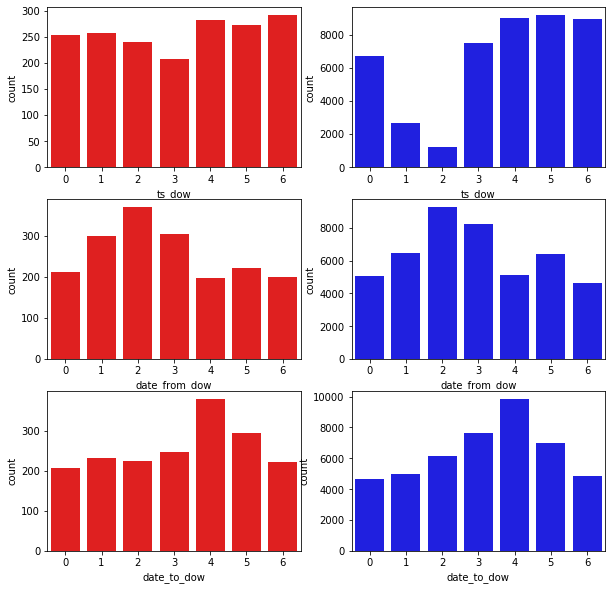

In [91]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
for idx, col in enumerate(datetime_columns):
    col_name = col+'_dow'
    sns.countplot(df_event[df_event['event_type'] == 'book'][col_name],
              color="red", label="book", ax=ax[idx, 0])
    sns.countplot(df_event[df_event['event_type'] == 'search'][col_name],
              color="blue", label="search", ax=ax[idx, 1])

##### [ Comments ]
Featrue : 'ts_dow' shows different patterns between 'book' and 'search'.



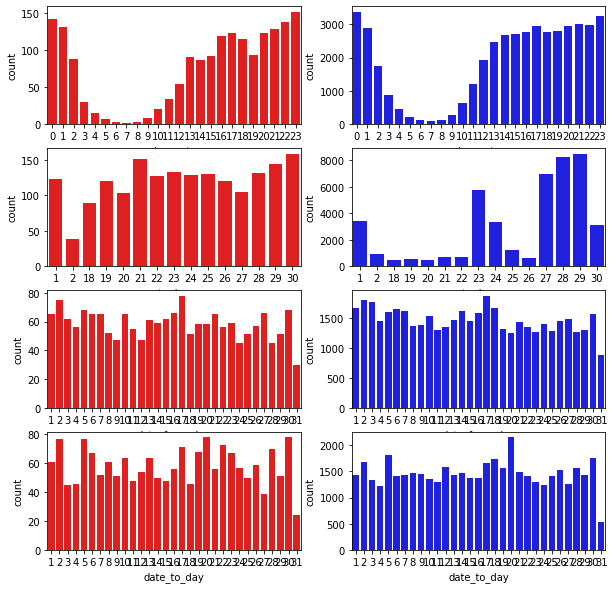

In [94]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
for idx, col in enumerate(df_event.columns[-5:-1]):
    sns.countplot(df_event[df_event['event_type'] == 'book'][col],
              color="red", label="book", ax=ax[idx, 0])
    sns.countplot(df_event[df_event['event_type'] == 'search'][col],
              color="blue", label="search", ax=ax[idx, 1])

##### [ Comments ]
Featrue : 'ts_day' count distribution shows differeces between 'book' and 'search'.



(0, 50)

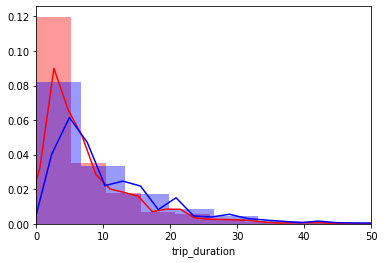

In [50]:
ax = sns.distplot(df_event[df_event['event_type'] == 'book']['trip_duration'],
          color="red", label="book")
ax = sns.distplot(df_event[df_event['event_type'] == 'search']['trip_duration'],
          color="blue", label="search")

ax.set_xlim([0,50])

##### [ Comments ]
Featrue : 'trip_duration' distribution is slightly different between 'book' and 'search'.



#### D. Add distance in km (haversine distance)
Calculate the haversine distance between origin and destination <br>
The distance is calculated with 'haversine_distance' function defined in utils.py.

In [166]:
df_event['trip_distance'] = get_trip_distance(df_event[['origin', 'destination']], df_iata)


In [167]:
df_event[df_event['trip_distance'].isna()]

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,act_count,diff_ts,ts_dow,date_from_dow,date_to_dow,hours_ts,ts_day,date_from_day,date_to_day,trip_duration,trip_distance


(0, 20000)

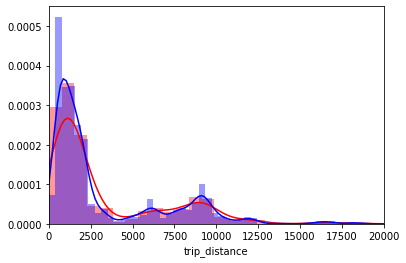

In [170]:
ax = sns.distplot(df_event[df_event['event_type']=='book']['trip_distance'],
            color="red", label="book")
ax = sns.distplot(df_event[df_event['event_type']=='search']['trip_distance'],
            color="blue", label="search")
ax.set_xlim([0,20000])

##### [ Comments ]
Featrue : 'trip_distance' distribution is slightly different between 'book' and 'search'.



In [172]:
df_event.head(3)

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,act_count,diff_ts,ts_dow,date_from_dow,date_to_dow,hours_ts,ts_day,date_from_day,date_to_day,trip_duration,trip_distance
10873,2017-04-29 17:59:51,search,000069,2017-05-10,2017-05-26,FRA,ALG,2,3,1,0.0,5,2,4,17,29,10,26,16,1553.715579
12331,2017-04-28 19:14:23,search,00019d,2017-09-15,2017-10-13,PAR,SSA,4,0,1,0.0,4,4,4,19,28,15,13,28,1553.715579
26506,2017-04-24 21:25:10,search,0002e3,2017-05-01,2017-05-01,PAR,ATH,1,0,1,0.0,0,0,0,21,24,1,1,0,1553.715579


To keep the datatype, featured file save to parquet

In [175]:
df_event.to_parquet('./data/events.parquet', index=False)